In [1]:
%matplotlib inline

import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [321]:
def readMatrix(file):
    fd = open(file, 'r')
    hdr = fd.readline()
    rows, cols = [int(s) for s in fd.readline().strip().split()]
    tokens = fd.readline().strip().split()
    matrix = np.zeros((rows, cols))
    Y = []
    for i, line in enumerate(fd):
        nums = [int(x) for x in line.strip().split()]
        Y.append(nums[0])
        kv = np.array(nums[1:])
        k = np.cumsum(kv[:-1:2])
        v = kv[1::2]
        matrix[i, k] = v
    return matrix, tokens, np.array(Y)

def nb_train(matrix, category):
    state = {}
    N = matrix.shape[1]
    ###################
    category = category.reshape((category.shape[0], 1))
    total_y_1 = np.sum(category)
    total_y_0 = category.shape[0] - total_y_1
    phi_y = total_y_1 / category.shape[0] # scalar representing probability of spam
    
    #print(f'phi_y={phi_y}')
    # (1 x v) vector representing probability word IS NOT present in doc, i.e. P(x | y == 0)
    phi_j_0 = (1 + np.sum( (matrix > 0) * (1 - category), axis=0)) / (2 + total_y_0)
    phi_j_0 = phi_j_0.reshape((phi_j_0.shape[0], 1))
    #print(f'phi_j_0.shape={phi_j_0.shape}')
    
    # (1 x v) vector representing probability word IS present in doc, i.e. P(x | y == 1)
    phi_j_1 = (1 + np.sum((matrix > 0) * category, axis=0)) / (2 + total_y_1)
    phi_j_1 = phi_j_1.reshape((phi_j_0.shape[0], 1))
    #print(f'phi_j_1.shape={phi_j_1.shape}')
    
    # (1 x v) vector representing probability word IS present in doc, i.e. p(x)
    prob_x = (phi_j_0 * (1 - phi_y)) + phi_j_1 * phi_y
    #print(f'prob_x.shape={prob_x.shape}')
    
    state['phi_y'] = phi_y
    state['phi_j_0'] = phi_j_0
    state['phi_j_1'] = phi_j_1
    
    state['divergence'] = ((phi_j_1 / phi_j_0)).reshape(phi_j_1.shape[0])
    ###################
    return state

def nb_test(matrix, state):
    output = np.zeros(matrix.shape[0])
    ###################
    phi_y = state['phi_y']
    phi_j_0 = state['phi_j_0']
    phi_j_1 = state['phi_j_1']
    
    i_matrix = (matrix > 0)
    p_x_y_1 = i_matrix.dot(phi_j_1) * phi_y
    p_x_y_0 = i_matrix.dot(phi_j_0) * (1 - phi_y)
    
    ln_p_x_y_1 = np.sum(np.ma.log(p_x_y_1).filled(0), axis = 1)
    ln_p_x_y_0 = np.sum(np.ma.log(p_x_y_0).filled(0), axis = 1)

    #print(f'nb_test(): ln_p_x_y_1.shape={ln_p_x_y_1.shape}')
    #print(f'nb_test(): ln_p_x_y_0.shape={ln_p_x_y_1.shape}')

    Prob_x_y_1 = np.exp(ln_p_x_y_1)
    Prob_x_y_0 = np.exp(ln_p_x_y_0)
          
    Prob_y_x = Prob_x_y_1 / (Prob_x_y_1 + Prob_x_y_0)

    #print(f'nb_test(): Prob_y_x.shape={Prob_y_x.shape}')
    #print(f'nb_test(): Prob_x_y_0.shape={Prob_x_y_0.shape}')
    #print(f'nb_test(): Prob_x_y_1.shape={Prob_x_y_1.shape}')
    output = Prob_y_x > 0.5
    ###################
    return output

def evaluate(output, label):
    error = (output != label).sum() * 1. / len(output)
    print('Error: %1.4f' % error)
    return error

def main():
    trainMatrix, tokenlist, trainCategory = readMatrix('data/MATRIX.TRAIN')
    testMatrix, tokenlist, testCategory = readMatrix('data/MATRIX.TEST')

    state = nb_train(trainMatrix, trainCategory)
    output = nb_test(testMatrix, state)

    evaluate(output, testCategory)
    return

In [322]:
trainMatrix, tokenlist, trainCategory = readMatrix('data/MATRIX.TRAIN')

In [323]:
testMatrix, tokenlist, testCategory = readMatrix('data/MATRIX.TEST')

In [324]:
trainMatrix.shape

(2144, 1448)

In [325]:
trainCategory.shape

(2144,)

In [326]:
state = nb_train(trainMatrix, trainCategory)

In [327]:
state['phi_y']

0.49906716417910446

In [328]:
state['divergence'][0:10]

array([1.06646455, 2.32112873, 1.20447761, 1.68809362, 0.58110762,
       0.47234416, 2.32292111, 0.61339138, 0.75791959, 0.84524745])

In [329]:
state['divergence'].shape

(1448,)

In [330]:
state['divergence'][0:5]

array([1.06646455, 2.32112873, 1.20447761, 1.68809362, 0.58110762])

In [331]:
top_5_divergent_words = (-state['divergence']).argsort()[:50]

In [332]:
top_5_divergent_words

array([1209,  615, 1356, 1403,  758,  221,  305, 1402,  429,  848,   45,
       1268,  204,  727, 1056,  266,  676,  308,   96,  786,  352, 1355,
        614, 1057, 1368,  884, 1357,  909,  281,  834,  812,  862,   74,
        592,  384,  506, 1145, 1439,  979,  604,  978,  612, 1249,  154,
       1264,  261, 1010,  641,  885,  744])

In [333]:
output = nb_test(testMatrix, state)

In [334]:
evaluate(output, testCategory)

Error: 0.0013


0.00125

0
Error: 0.2362
1
Error: 0.0688
2
Error: 0.0088
3
Error: 0.0013
4
Error: 0.0013
5
Error: 0.0013
[0.23625, 0.06875, 0.00875, 0.00125, 0.00125, 0.00125]


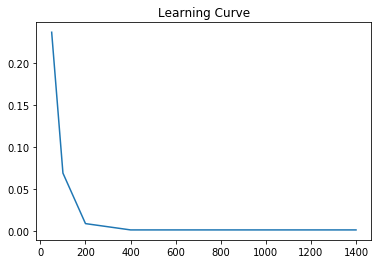

In [337]:
suffices = [50, 100, 200, 400, 800, 1400]
error_rates = []

for index, suffix in enumerate(suffices):
    filename = 'data/MATRIX.TRAIN.' + str(suffix)
    print(index)
    trainMatrix, tokenlist, trainCategory = readMatrix(filename)
    testMatrix, tokenlist, testCategory = readMatrix('data/MATRIX.TEST')
    state = nb_train(trainMatrix, trainCategory)
    output = nb_test(testMatrix, state)
    error_rates.append(evaluate(output, testCategory))
print(error_rates)
plt.title('Learning Curve')
plt.plot(suffices, error_rates)

In [344]:
tau = 8.

def readMatrixSVM(file):
    fd = open(file, 'r')
    hdr = fd.readline()
    rows, cols = [int(s) for s in fd.readline().strip().split()]
    tokens = fd.readline().strip().split()
    matrix = np.zeros((rows, cols))
    Y = []
    for i, line in enumerate(fd):
        nums = [int(x) for x in line.strip().split()]
        Y.append(nums[0])
        kv = np.array(nums[1:])
        k = np.cumsum(kv[:-1:2])
        v = kv[1::2]
        matrix[i, k] = v
    category = (np.array(Y) * 2) - 1
    return matrix, tokens, category

def svm_train(matrix, category):
    state = {}
    M, N = matrix.shape
    #####################
    Y = category
    matrix = 1. * (matrix > 0)
    squared = np.sum(matrix * matrix, axis=1)
    gram = matrix.dot(matrix.T)
    K = np.exp(-(squared.reshape((1, -1)) + squared.reshape((-1, 1)) - 2 * gram) / (2 * (tau ** 2)) )

    alpha = np.zeros(M)
    alpha_avg = np.zeros(M)
    L = 1. / (64 * M)
    outer_loops = 40

    alpha_avg
    for ii in range(outer_loops * M):
        i = int(np.random.rand() * M)
        margin = Y[i] * np.dot(K[i, :], alpha)
        grad = M * L * K[:, i] * alpha[i]
        if (margin < 1):
            grad -=  Y[i] * K[:, i]
        alpha -=  grad / np.sqrt(ii + 1)
        alpha_avg += alpha

    alpha_avg /= (ii + 1) * M

    state['alpha'] = alpha
    state['alpha_avg'] = alpha_avg
    state['Xtrain'] = matrix
    state['Sqtrain'] = squared
    ####################
    return state

def svm_test(matrix, state):
    M, N = matrix.shape
    output = np.zeros(M)
    ###################
    Xtrain = state['Xtrain']
    Sqtrain = state['Sqtrain']
    matrix = 1. * (matrix > 0)
    squared = np.sum(matrix * matrix, axis=1)
    gram = matrix.dot(Xtrain.T)
    K = np.exp(-(squared.reshape((-1, 1)) + Sqtrain.reshape((1, -1)) - 2 * gram) / (2 * (tau ** 2)))
    alpha_avg = state['alpha_avg']
    preds = K.dot(alpha_avg)
    output = np.sign(preds)
    ###################
    return output

def evaluate(output, label):
    error = (output != label).sum() * 1. / len(output)
    print('Error: %1.4f' % error)
    return error

def main():
    trainMatrix, tokenlist, trainCategory = readMatrixSVM('MATRIX.TRAIN.400')
    testMatrix, tokenlist, testCategory = readMatrixSVM('MATRIX.TEST')

    state = svm_train(trainMatrix, trainCategory)
    output = svm_test(testMatrix, state)

    evaluate(output, testCategory)
    return

0
Error: 0.0138
1
Error: 0.0112
2
Error: 0.0025
3
Error: 0.0025
4
Error: 0.0000
5
Error: 0.0000


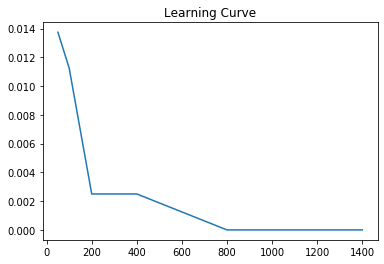

In [345]:
suffices = [50, 100, 200, 400, 800, 1400]
error_rates = []

for index, suffix in enumerate(suffices):
    filename = 'data/MATRIX.TRAIN.' + str(suffix)
    print(index)
    trainMatrix, tokenlist, trainCategory = readMatrixSVM(filename)
    testMatrix, tokenlist, testCategory = readMatrixSVM('data/MATRIX.TEST')
    state = svm_train(trainMatrix, trainCategory)
    output = svm_test(testMatrix, state)
    error_rates.append(evaluate(output, testCategory))
plt.title('Learning Curve')
plt.plot(suffices, error_rates)

In [346]:
error_rates

[0.01375, 0.01125, 0.0025, 0.0025, 0.0, 0.0]

### We see SVM converges far more quickly than Naïve Bayes